In [13]:
import numpy as np

##################################################
##### Matplotlib boilerplate for consistency #####
##################################################
from ipywidgets import interact
from ipywidgets import FloatSlider, IntSlider
from matplotlib import pyplot as plt

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

global_fig_width = 8
global_fig_height = global_fig_width / 1.61803399
font_size = 12

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.edgecolor'] = '0.8'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelpad'] = 8
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlepad'] = 16.0
plt.rcParams['axes.titlesize'] = font_size * 1.4
plt.rcParams['figure.figsize'] = (global_fig_width, global_fig_height)
plt.rcParams['font.sans-serif'] = ['Computer Modern Sans Serif', 'DejaVu Sans', 'sans-serif']
plt.rcParams['font.size'] = font_size
plt.rcParams['grid.color'] = '0.8'
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams['lines.dash_capstyle'] = 'round'
plt.rcParams['lines.dashed_pattern'] = [1, 4]
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['xtick.major.pad'] = 4
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['ytick.major.pad'] = 4
plt.rcParams['ytick.major.size'] = 0
##################################################

## Generating independent samples: sine curve

**Question:** how can we generate independent samples from the following (un-normalised) PDF?

In [14]:
def show_pdf():
    x = np.linspace(0,4*np.pi,100)
    y = 0.5*(1 + np.sin(2*(x-np.pi/4)))
    plt.plot(x,y)
    plt.fill_between(x,y,alpha=0.2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$P(x)$')
    plt.show()

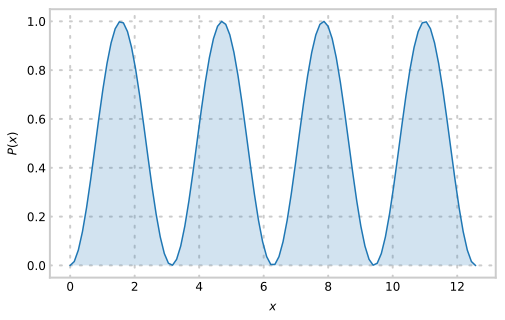

In [15]:
show_pdf()

**Answer:** do the following a large number of times:
1. Generate $x$ coordinates: uniformly-distributed points from $(0, 4\pi)$; where $4\pi$ is the domain of the function.
2. Generate $y$ coordinates: uniformly-distributed points from $(0, 1)$; where 1 is the maximum value of the function.
3. If $y < P(x)$, then accept $x$ coordinate as a sample.
4. If $y \ge P(x)$, then reject $x$ coordinate as a sample.
Known as **Rejection** sampling.

In [16]:
def P(x):
    return 0.5*(1 + np.sin(2*(x-np.pi/4)))

N = 100000
x = np.random.uniform(0,4*np.pi,N)
y = np.random.uniform(0,1,N)
x_samples = x[y < P(x)]

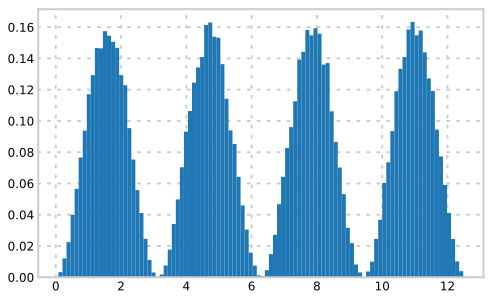

In [17]:
plt.hist(x_samples,bins=100,density=True)
plt.show()

## Why do sampling in the first place?

Samples from the posterior:

$$P(\theta | data) = \frac{P(data|\theta) P(\theta)}{P(data)}$$

- Shows the likely *distribution* of parameters, rather than single most likely point. Shows:
 - Correlated parameters
 - Unidentifiable parameters
 - Confidence intervals

## Why do sampling in the first place?

- Often, want to calculate the posterior mean of some parameter, $\theta_1$:
    
$$
E(\theta_1|X) = \int_{\theta_1} \int_{\theta_{-1}} 
\theta_1  P(\theta_1, \theta_{-1} | X)d \theta_{-1} d \theta_1
$$

where $\theta_{-1}$ corresponds to the $d − 1$ other parameters of the
model.

- Posterior mean can be approximated by summing over posterior samples

- Marginal distributions can also be obtained from posterior samples:

$$
P(\theta_1|X) = \int_{\theta_{-1}} P(\theta_1, \theta_{-1} | X)d \theta_{-1}
$$

## Why is generating independent samples difficult?

- **Rejection sampling** requires generation of a large number
of random points to produce relatively few samples.
- This inefficiency increases (exponentially) with the
dimensionality of the distribution; i.e. for posteriors with
more parameters.
- Other methods exist (inverse-transform sampling and
importance sampling, for example) but they suffer from
complexity and/or inefficiency issues.
- We cannot calculate the denominator so are unable to use
some of these methods.
- Even if we had the denominator the complexity of most
models means that independent sampling isn’t possible.

## Is sampling finished?

<center>
<img src="fig/sad-clown.jpg"> 
</center>

## What is dependent sampling?

- A sampling algorithm where the next sample depends on the current value, and the list of all (accepted) positions of the
sampler form the sample.

**Example dependent sampler:** 

choose a new
position based on a local “jumping” distribution
Suppose the next value of the sampler is drawn from a 2d
normal distribution centred on our current position.

In [18]:
# show dependent sampler here?

## Dependent samplers as Markov Chains (Monte Carlo)

- Where to step next is determined via a distribution
conditional on the current parameter value.
- This stepping is probabilistic $\rightarrow$ *Monte Carlo*.
- The conditional distribution only depends on the current
value of the sampler meaning it is memoryless about past
path.
- This memoryless means that the path of the sampler is a
*1st order Markov Chain*.

## Open questions

How can we decide on the:
1. Starting position.
2. Jumping distribution’s shape.

To ensure convergence to the posterior distribution? Especially
because we cannot compute the posterior itself!

# Random Walk Metropolis

A discrete example: **David Robinson’s fishing**
    
- David Robinson (a more fortunate cousin of Robinson
Crusoe) is marooned on an island.
- Access to four freshwater lakes of different sizes; each with
a supply of fish.

<center>
<img src="fig/david_robinson.svg"> 
</center>

## David Robinson’s fishing

- He has a terrible memory (too much coconut toddy), and
each day forgets any estimates of lake size he made
previously.
- He wants to fish (at maximum) one new lake per day.
- He possesses a coin and a solar-powered calculator that
can generate (pseudo-)random numbers uniformly
distributed between 0 and 1.
- He is initially “washed up” next to lake A.

<center>
<img src="fig/david_robinson.svg"> 
</center>

**Question:** What strategy should he use to fish as
sustainably as possible?

**Remember:** Robinson doesn’t know the # of lakes, nor
the amount of fish in each!

<center>
<img src="fig/david_robinson.svg"> 
</center>

**Answer:** visit each lake in proportion to the fish it contains, by
doing the following:
1. Each night he flips the coin.
2. If it’s heads (tails) he proposes a move to the neighbouring
lake in the clockwise (anticlockwise) direction.
3. Calculates the ratio of the size of the proposed lake to the
current one.
4. Compares the ratio with a (pseudo-)random number from
the calculator.
5. If the ratio exceeds the generated number, he moves. If
not, he stays put and fishes the same lake tomorrow.

## David Robinson’s fishing: does it work?

In [35]:
N = 100
x = [0, 1, 2, 3]
lakes = [2.0, 1.0, 4.0, 2.0]
days = np.zeros((4,N))
current_lake = 0

for i in range(1,N):
    days[:,i] = days[:,i-1]
    
    # move either clockwise or counter-clockwise
    proposed_lake = current_lake + 2*int(np.random.uniform() < 0.5) - 1
    if proposed_lake > 3:
        proposed_lake = 0;
    elif proposed_lake < 0:
        proposed_lake = 3
        
    # accept move based on the ratio of lake sizes
    ratio = lakes[proposed_lake]/lakes[current_lake]
    if ratio > np.random.uniform():
        current_lake = proposed_lake
        
    days[current_lake, i] += 1

In [41]:
def plot_david_robinson(i):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8/1.618))
    ax1.plot(x, days[:,i], 'bo', ms=8, label='poisson pmf')
    ax1.vlines(x, 0, days[:,i], colors='b', lw=5, alpha=0.5)
    ax2.plot(x, lakes, 'bo', ms=8, label='poisson pmf')
    ax2.vlines(x, 0, lakes, colors='b', lw=5, alpha=0.5)
    ax1.set_ylim(0,N/2)
    plt.show()

day_widget = IntSlider(value=5, min=0, max=N-1, step=1, continuous_update=False)

In [42]:
interact(plot_david_robinson, i=day_widget, continuous_update=False);

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT01LCBjb250aW51b3VzX3VwZGF0ZT1GYWxzZSwgZGVzY3JpcHRpb249dSdpJywgbWF4PTk5KSwgT3V0cHV0KCkpLCBfZG9tX2PigKY=


## David Robinson’s fishing: summary

- Robinson lacked knowledge of numbers of fish in each lake and the number of lakes.
- Only knows that the number of fish in each lake is proportionate to its size.
- His memory stops him remembering the exact sizes.
- After about 100 days his “random” strategy is quite similar from an “omniscient” one.

## Defining Random Walk Metropolis

Robinson’s strategy is an example of the “Random Walk Metropolis” algorithm. This has the following form:

- Generate a random starting location $\theta_0$.
- Iterate the following for $t = 1, ..,T$:
  - Propose a new location from a jumping distribution: 
$$\theta_{t+1} \sim J(\theta_{t+1}|\theta_t)$$.
  - Calculate the ratio: 
$$r = \frac{\text{likelihood}(\theta_{t+1}) \times \text{prior}(\theta_{t+1})}{\text{likelihood}(\theta_t) \times \text{prior}(\theta_t)}$$
  - Compare $r$ with a uniformly-distributed number $u$ between 0 and 1.
  - If $r \ge u \Rightarrow$ we move.
  - Otherwise, we remain at our current position.

In [ ]:
# demo of mcmc here?

## Random Walk Metropolis: benefits
- Under quite general conditions the Random Walk
Metropolis sampler converges asymptotically to the
posterior.
- However for a sufficiently large sample size the sampling
distribution may be practically indistinguishable from the
true posterior.
- The algorithm requires us to be able to calculate the ratio:

$$r = \frac{\text{likelihood}(\theta_{t+1}) \times \text{prior}(\theta_{t+1})}{\text{likelihood}(\theta_t) \times \text{prior}(\theta_t)}$$

- The ratio uses only the numerator of Bayes’ rule $\Rightarrow$ we
side-step calculating the denominator!